In [7]:
folder = "irb/111"
SESSION_ID = "CHI2019"

In [15]:
import json, os, csv, platform, datetime, time
from glob import glob
import numpy as np
from pprint import pprint
from matplotlib import pyplot as pl

DATA_ROOT = "irb"

E4_MANIFEST = {
    'phasic': {
        'name': "Phasic GSR",
        'description': "Event-specific EDA"
    },
    'smna':{
        'name': "SMNA",
        'description': "sparse SMNA driver of phasic component"
    },
    'temp': {
        'name': "Temperature",
        'description': "Data from temperature sensor expressed degrees on the Celsius (°C) scale.",
        'unit': "celsius"
    },
    'tags':{
        'name': "Tags",
        'description': "Event mark times. Each row corresponds to a physical button press on the device; the same time as the status LED is first illuminated. The time is expressed as a unix timestamp in UTC and it is synchronized with initial time of the session indicated in the related data files from the corresponding session."
    },
    'acc':{
        'description': "Data from 3-axis accelerometer sensor. The accelerometer is configured to measure acceleration in the range [-2g, 2g]. Therefore the unit in this file is 1/64g. Data from x, y, and z axis are respectively in first, second, and third column.",
        'name': "3-Axis Accelerometer",
        'unit': "1/64g"
    }, 
    'eda':{
        'description': "Data from the electrodermal activity sensor expressed as microsiemens (μS).", 
        'name':"Electrodermal Activity",
        'unit': "μS"
    }, 
    'bvp':{
        'name': "Blood Volume Pulse (BVP) from PPG",
        'description': "Data from photoplethysmograph.",
    }, 
    'ibi':{
        'name': "IBI", 
        'description': "Time between individuals heart beats extracted from the BVP signal. No sample rate is needed for this file. The first column is the time (respect to the initial time) of the detected inter-beat interval expressed in seconds (s). The second column is the duration in seconds (s) of the detected inter-beat interval (i.e., the distance in seconds from the previous beat)."
    },
    'hr':{
        'name': "Heart rate", 
        'description': "Average heart rate extracted from the BVP signal.The first row is the initial time of the session expressed as unix timestamp in UTC. The second row is the sample rate expressed in Hz."
    }
}

def save_jsonfile(name, data):
    with open(name, 'w') as outfile:
        json.dump(data, outfile)
    print("File saved!", name)


In [16]:
# %load lib/cvxEDA.py
"""
______________________________________________________________________________

 File:                         cvxEDA.py
 Last revised:                 07 Nov 2015 r69
 ______________________________________________________________________________

 Copyright (C) 2014-2015 Luca Citi, Alberto Greco
 
 This program is free software; you can redistribute it and/or modify it under
 the terms of the GNU General Public License as published by the Free Software
 Foundation; either version 3 of the License, or (at your option) any later
 version.
 
 This program is distributed in the hope that it will be useful, but WITHOUT
 ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS
 FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details.
 
 You may contact the author by e-mail (lciti@ieee.org).
 ______________________________________________________________________________

 This method was first proposed in:
 A Greco, G Valenza, A Lanata, EP Scilingo, and L Citi
 "cvxEDA: a Convex Optimization Approach to Electrodermal Activity Processing"
 IEEE Transactions on Biomedical Engineering, 2015
 DOI: 10.1109/TBME.2015.2474131

 If you use this program in support of published research, please include a
 citation of the reference above. If you use this code in a software package,
 please explicitly inform the end users of this copyright notice and ask them
 to cite the reference above in their published research.
 ______________________________________________________________________________
"""

import numpy as np
import cvxopt as cv
import cvxopt.solvers

def cvxEDA(y, delta, tau0=2., tau1=0.7, delta_knot=10., alpha=8e-4, gamma=1e-2,
           solver=None, options={'reltol':1e-9}):
    """CVXEDA Convex optimization approach to electrodermal activity processing

    This function implements the cvxEDA algorithm described in "cvxEDA: a
    Convex Optimization Approach to Electrodermal Activity Processing"
    (http://dx.doi.org/10.1109/TBME.2015.2474131, also available from the
    authors' homepages).

    Arguments:
       y: observed EDA signal (we recommend normalizing it: y = zscore(y))
       delta: sampling interval (in seconds) of y
       tau0: slow time constant of the Bateman function
       tau1: fast time constant of the Bateman function
       delta_knot: time between knots of the tonic spline function
       alpha: penalization for the sparse SMNA driver
       gamma: penalization for the tonic spline coefficients
       solver: sparse QP solver to be used, see cvxopt.solvers.qp
       options: solver options, see:
                http://cvxopt.org/userguide/coneprog.html#algorithm-parameters

    Returns (see paper for details):
       r: phasic component
       p: sparse SMNA driver of phasic component
       t: tonic component
       l: coefficients of tonic spline
       d: offset and slope of the linear drift term
       e: model residuals
       obj: value of objective function being minimized (eq 15 of paper)
    """

    n = len(y)
    y = cv.matrix(y)

    # bateman ARMA model
    a1 = 1./min(tau1, tau0) # a1 > a0
    a0 = 1./max(tau1, tau0)
    ar = np.array([(a1*delta + 2.) * (a0*delta + 2.), 2.*a1*a0*delta**2 - 8.,
        (a1*delta - 2.) * (a0*delta - 2.)]) / ((a1 - a0) * delta**2)
    ma = np.array([1., 2., 1.])

    # matrices for ARMA model
    i = np.arange(2, n)
    A = cv.spmatrix(np.tile(ar, (n-2,1)), np.c_[i,i,i], np.c_[i,i-1,i-2], (n,n))
    M = cv.spmatrix(np.tile(ma, (n-2,1)), np.c_[i,i,i], np.c_[i,i-1,i-2], (n,n))

    # spline
    delta_knot_s = int(round(delta_knot / delta))
    spl = np.r_[np.arange(1.,delta_knot_s), np.arange(delta_knot_s, 0., -1.)] # order 1
    spl = np.convolve(spl, spl, 'full')
    spl /= max(spl)
    # matrix of spline regressors
    i = np.c_[np.arange(-(len(spl)//2), (len(spl)+1)//2)] + np.r_[np.arange(0, n, delta_knot_s)]
    nB = i.shape[1]
    j = np.tile(np.arange(nB), (len(spl),1))
    p = np.tile(spl, (nB,1)).T
    valid = (i >= 0) & (i < n)
    B = cv.spmatrix(p[valid], i[valid], j[valid])

    # trend
    C = cv.matrix(np.c_[np.ones(n), np.arange(1., n+1.)/n])
    nC = C.size[1]

    # Solve the problem:
    # .5*(M*q + B*l + C*d - y)^2 + alpha*sum(A,1)*p + .5*gamma*l'*l
    # s.t. A*q >= 0

    old_options = cv.solvers.options.copy()
    cv.solvers.options.clear()
    cv.solvers.options.update(options)
    if solver == 'conelp':
        # Use conelp
        z = lambda m,n: cv.spmatrix([],[],[],(m,n))
        G = cv.sparse([[-A,z(2,n),M,z(nB+2,n)],[z(n+2,nC),C,z(nB+2,nC)],
                    [z(n,1),-1,1,z(n+nB+2,1)],[z(2*n+2,1),-1,1,z(nB,1)],
                    [z(n+2,nB),B,z(2,nB),cv.spmatrix(1.0, range(nB), range(nB))]])
        h = cv.matrix([z(n,1),.5,.5,y,.5,.5,z(nB,1)])
        c = cv.matrix([(cv.matrix(alpha, (1,n)) * A).T,z(nC,1),1,gamma,z(nB,1)])
        res = cv.solvers.conelp(c, G, h, dims={'l':n,'q':[n+2,nB+2],'s':[]})
        obj = res['primal objective']
    else:
        # Use qp
        Mt, Ct, Bt = M.T, C.T, B.T
        H = cv.sparse([[Mt*M, Ct*M, Bt*M], [Mt*C, Ct*C, Bt*C], 
                    [Mt*B, Ct*B, Bt*B+gamma*cv.spmatrix(1.0, range(nB), range(nB))]])
        f = cv.matrix([(cv.matrix(alpha, (1,n)) * A).T - Mt*y,  -(Ct*y), -(Bt*y)])
        res = cv.solvers.qp(H, f, cv.spmatrix(-A.V, A.I, A.J, (n,len(f))),
                            cv.matrix(0., (n,1)), solver=solver)
        obj = res['primal objective'] + .5 * (y.T * y)
    cv.solvers.options.clear()
    cv.solvers.options.update(old_options)

    l = res['x'][-nB:]
    d = res['x'][n:n+nC]
    t = B*l + C*d
    q = res['x'][:n]
    p = A * q
    r = M * q
    e = y - r - t

    return (np.array(a).ravel() for a in (r, p, t, l, d, e, obj))


In [17]:
def get_file(folder, prefix):
    user = os.path.basename(folder)
    files = glob(folder + "/"+prefix+"*.json")
    if len(files) == 0:
        print("File not found", prefix, 'in', folder)
        return None
    else: 
        with open(files[0], 'r+') as f: 
            contents = json.load(f)
            return contents, files[0]
    

# Cleaning Routine

In [18]:
contents, f = get_file(folder, "eda")

In [44]:
# MAKING A SESSION METADATA JSON
def session_metadata(folder):
    contents, filename = get_file(folder, "acc")
    directory = os.path.dirname(filename)
    filename, ext = os.path.basename(filename).split('.')
    filetype, user_id = filename.split("_")
    data = {}
    data['session_start'] = session_start
    data['session_end'] = session_end
    data['elapsed_time'] = session_end - session_start
    
    log = ["ACC_START", time.ctime(eda_start), "SESSION_START", time.ctime(session_start), "SESSION_END", time.ctime(session_end), "ELAPSED", str(end-start)]
    data['description'] =  "\n".join(log)
    save_jsonfile(os.path.join(directory, "sessionmetadata" + "_" + user_id + ".json"), data)


In [45]:
def find_session(folder, start):
    contents, filename = get_file(folder, "acc")
    fig, ax = pl.subplots()
    
    eda_start = None
    eda_Fs = None
    
#     print(contents)
    data = contents["data"]

    eda_start = contents["timestamp"]
    eda_Fs = contents["sampling_rate"]

    # PLOTTING ACCELERATION VALUES       
    data = np.array(data, dtype='f')
    ax.plot(data[:, 0], 'r')
    ax.plot(data[:, 1], 'g')
    ax.plot(data[:, 2], 'b')

    # ADDING TAG EVENTS
    contents, f = get_file(folder, "tags")
    data = contents["data"]
    for tag in data:
        elapsed_time = tag - eda_start
        x = elapsed_time * eda_Fs                
        ax.axvline(x=x)

    # ADD LOG EVENTS
    contents, f = get_file(folder, "log") 
    data = contents["data"]

    timestamps = [d['time']/1000 for d in data]
    for tag in timestamps:
        elapsed_time = tag - eda_start
        x = elapsed_time * eda_Fs    
        ax.axvline(x=x, color='y')


    def onclick(event):
        global edaFs, eda_start
        ix, iy = event.xdata, event.ydata
        if start:
            global session_start
            session_start = eda_start + (ix/eda_Fs)
        else:
            global session_end
            session_end = eda_start + (ix/eda_Fs)
        return False
    def handle_close(evt):
        print('Closed Figure!')
        print("START", time.ctime(eda_start))

    cid = fig.canvas.mpl_connect('close_event', handle_close)
    cid = fig.canvas.mpl_connect('button_press_event', onclick)
    return eda_start, eda_Fs

In [46]:
#FIND SESSION START
session_start = None
eda_start, edaFs = find_session(folder, True)

Closed Figure!
START Tue Aug 28 13:22:27 2018


In [40]:
# FIND SESSION END
session_end = None
eda_start, edaFs = find_session(folder, False)

In [47]:
# REVIEW INFORMATION
end = datetime.datetime.fromtimestamp(session_end)
start = datetime.datetime.fromtimestamp(session_start)

print(time.ctime(eda_start))
print(time.ctime(session_start))
print(time.ctime(session_end))
print("ELAPSED", str(end-start))

Tue Aug 28 13:22:27 2018
Tue Aug 28 13:27:02 2018
Tue Aug 28 13:46:39 2018
ELAPSED 0:19:36.838636


In [48]:
# HAPPY?
session_metadata(folder)

File saved! irb/111/sessionmetadata_111.json


# EDA ANALYSIS
* r: phasic component - event related
* p: sparse SMNA driver of phasic component
* t: tonic component
* l: coefficients of tonic spline
* d: offset and slope of the linear drift term
* e: model residuals
* obj: value of objective function being minimized (eq 15 of paper)

In [85]:
import pylab as pl
def process_eda(folder):
    user = os.path.basename(folder)
    contents, filename = get_file(folder, "eda")
    directory = os.path.dirname(filename)
    filename, ext = os.path.basename(filename).split('.')
    filetype, user_id = filename.split("_")

    Fs = contents["sampling_rate"]
    y = contents["data"]
    y = np.array(y)
    
    
    

    metadata,f = get_file(folder, "sessionmetadata")
    
    
    # ADJUST Y AND T RANGE    
    t = contents["timestamp"]
    start = metadata["session_start"] - t
    end = metadata["session_end"] - t    
    t0 = start * Fs 
    t0 = start * Fs  if start > 0 else 0
    tf = end * Fs - 1 if end < len(y) else len(y)
    y = y[t0:tf]
    tm = pl.arange(1., len(y)+1.) / Fs
    # END ADJUSTMENT
    pl.plot(tm, y)

    yn = (y - y.mean()) / y.std()
    [r, p, t, l, d, e, obj] = cvxEDA(yn, 1./Fs)
    pl.plot(tm, r, 'r')
    pl.plot(tm, p, 'b')
    pl.show()

    metadata = {}
    metadata['user_id'] = int(user)
    metadata['session_id'] = SESSION_ID
    metadata['sampling_rate'] = Fs
    metadata['timestamp'] = start


    # MAKE PHASIC.JSON 
    metadata["data"] = r.tolist()
    data = dict(metadata, **E4_MANIFEST["phasic"])

    save_jsonfile(os.path.join(directory, "phasic" + "_" + user_id + ".json"), data)

    #MAKE SMNA
    metadata["data"] = r.tolist()
    data = dict(metadata, **E4_MANIFEST["smna"])
    save_jsonfile(os.path.join(directory, "smna" + "_" + user_id + ".json"), data)

    print("Processed eda data.")

Populating the interactive namespace from numpy and matplotlib
     pcost       dcost       gap    pres   dres
 0: -2.3337e+03 -2.3171e+03  7e+03  8e+01  4e-01
 1: -2.3376e+03 -3.0447e+03  8e+02  9e+00  5e-02
 2: -2.3429e+03 -2.5278e+03  2e+02  2e+00  1e-02
 3: -2.3440e+03 -2.4169e+03  7e+01  6e-01  3e-03
 4: -2.3444e+03 -2.3712e+03  3e+01  2e-01  9e-04
 5: -2.3455e+03 -2.3545e+03  9e+00  4e-02  2e-04
 6: -2.3482e+03 -2.3506e+03  2e+00  8e-03  4e-05
 7: -2.3491e+03 -2.3500e+03  9e-01  2e-03  1e-05
 8: -2.3494e+03 -2.3497e+03  3e-01  3e-04  2e-06
 9: -2.3496e+03 -2.3497e+03  1e-01  7e-05  4e-07

/Users/cearto/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:26: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future



10: -2.3496e+03 -2.3496e+03  3e-02  1e-05  5e-08
11: -2.3496e+03 -2.3496e+03  6e-03  2e-06  9e-09
12: -2.3496e+03 -2.3496e+03  1e-03  2e-07  8e-10
13: -2.3496e+03 -2.3496e+03  2e-04  1e-08  7e-11
14: -2.3496e+03 -2.3496e+03  2e-05  1e-09  6e-12
15: -2.3496e+03 -2.3496e+03  7e-07  3e-11  1e-13
Optimal solution found.


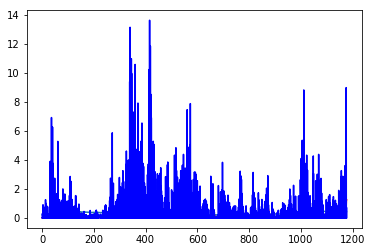

In [86]:
%pylab inline
process_eda(folder)